In [3]:
import numpy as np

np.int = np.int32
np.float = np.float64
np.bool = np.bool_

import pandas
import os
from pydantic import BaseModel, Field
from typing import Literal, List
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial
from rich import print as rprint
from IPython.display import Markdown, display

try:
    _SETUP
    print("Running on folder: ", os.getcwd())
except NameError:
    _SETUP = True
    os.chdir("..")
    print("Running on folder: ", os.getcwd())


# from llm.structured import create, create_iterable, create_sequence

Running on folder:  /Users/andre/test/ODSCB


In [4]:
class CustomerProperties(BaseModel):
    id: str
    age: int
    n_children: int
    marital_status: Literal["Single", "Married", "Divorced", "Widow", "Widower"]
    education: Literal["Basic", "Graduation", "Master", "PhD"]
    income: float
    online_spend: float
    store_spend: float
    received_offer: bool
    aov: float

    aov_after_campaign: float
    average_discount: float
    uplift: float

In [5]:
import numpy as np
import random
import uuid


def generate_synthetic_customer() -> CustomerProperties:
    """Generate synthetic customer data following realistic distributions"""

    # Generate random but realistic values
    # Age follows a skewed normal distribution centered around 45 with most customers between 25-65
    age = int(np.random.normal(45, 12))
    age = max(18, min(90, age))  # Clip to reasonable bounds

    # Younger people are more likely to have basic education, older more likely to have advanced degrees
    if age < 25:
        weights = [0.4, 0.5, 0.09, 0.01]  # More basic/graduation for young
    elif age < 35:
        weights = [0.2, 0.6, 0.15, 0.05]  # Peak graduation age
    elif age < 50:
        weights = [0.15, 0.45, 0.3, 0.1]  # More masters/PhD for middle age
    else:
        weights = [0.25, 0.4, 0.25, 0.1]  # Mixed distribution for older

    education = random.choices(
        ["Basic", "Graduation", "Master", "PhD"], weights=weights
    )[0]

    # Younger people less likely to have children, middle-aged more likely
    if age < 25:
        weights = [0.8, 0.15, 0.04, 0.01, 0]  # Mostly no children when very young
    elif age < 35:
        weights = [0.4, 0.35, 0.2, 0.04, 0.01]  # Growing family phase
    elif age < 50:
        weights = [0.2, 0.3, 0.35, 0.1, 0.05]  # Peak family size
    else:
        weights = [0.3, 0.3, 0.25, 0.1, 0.05]  # Mixed distribution for older
    n_children = random.choices([0, 1, 2, 3, 4], weights=weights)[0]

    # Marital status probabilities vary by age
    if age < 25:
        weights = [0.8, 0.15, 0.04, 0.01, 0]  # Mostly single when young
    elif age < 35:
        weights = [0.4, 0.45, 0.12, 0.02, 0.01]  # More marriages
    elif age < 50:
        weights = [0.2, 0.55, 0.2, 0.03, 0.02]  # Peak marriage years
    else:
        weights = [0.15, 0.45, 0.25, 0.08, 0.07]  # More divorced/widowed when older

    marital_status = random.choices(
        ["Single", "Married", "Divorced", "Widow", "Widower"], weights=weights
    )[0]

    # Income follows a log-normal distribution
    # Base income parameters adjusted by age and education
    base_mean = 10.5  # Base log income (~36k)

    # Age adjustment: Income tends to increase with age until ~55, then plateaus/slightly decreases
    age_factor = min((age - 18) * 0.03, 1.1)  # Max +110% increase

    # Education adjustment
    education_boost = {
        "Basic": 0,
        "Graduation": 0.3,  # +30% boost
        "Master": 0.6,  # +60% boost
        "PhD": 0.9,  # +90% boost
    }

    adjusted_mean = base_mean + np.log(
        (1 + age_factor) * (1 + education_boost[education])
    )
    income = float(np.random.lognormal(mean=adjusted_mean, sigma=0.4))

    # After income calculation, add spending pattern generation
    total_spending_capacity = income * random.uniform(
        0.01, 0.03
    )  # 1-3% of income for this category

    # Calculate online vs store split based on characteristics
    online_bias = 0.5  # Start with 50-50 split

    # Age factor: younger -> more online
    online_bias += (50 - age) * 0.01  # +/- 0.3 max

    # Education factor: higher education -> more online
    education_online_boost = {
        "Basic": -0.1,
        "Graduation": 0,
        "Master": 0.1,
        "PhD": 0.15,
    }
    online_bias += education_online_boost[education]

    # Children factor: more children -> more store
    online_bias -= n_children * 0.05

    # Clip to reasonable bounds (20-80% split)
    online_bias = max(0.2, min(0.8, online_bias))

    # Calculate final spending with some random variation
    online_spend = float(
        total_spending_capacity * (online_bias + random.uniform(-0.1, 0.1))
    )
    store_spend = float(
        total_spending_capacity * ((1 - online_bias) + random.uniform(-0.1, 0.1))
    )

    # Randomly assign if they received an offer
    # Calculate total spend and online ratio
    total_spend = online_spend + store_spend
    online_ratio = online_spend / total_spend if total_spend > 0 else 0.5

    # Base 50% chance modified by online ratio
    # For predominantly online customers (ratio ~0.8), chance becomes ~60%
    # For predominantly store customers (ratio ~0.2), chance becomes ~40%
    offer_probability = 0.5 * (1 + (online_ratio - 0.5))
    received_offer = random.random() < offer_probability

    # Calculate AOV (Average Order Value) before and after campaign
    # Only meaningful if they received an offer
    base_aov = (online_spend + store_spend) / random.uniform(
        8, 15
    )  # Assume 8-15 orders per period

    if received_offer:
        aov_before_campaign = base_aov

        # Calculate uplift factors
        # 1. Online vs Store factor (0.0 to 0.15)
        # Store-heavy customers get more uplift
        online_ratio = (
            online_spend / (online_spend + store_spend)
            if (online_spend + store_spend) > 0
            else 0.5
        )
        channel_uplift = 0.15 * (
            1 - online_ratio
        )  # max uplift for store-only customers

        # 2. Income factor (0.0 to 0.10)
        # Lower income gets higher uplift
        # Using log income since income is log-normally distributed
        log_income = np.log(income)
        min_log_income = np.log(30000)  # Assuming minimum income of 30k
        max_log_income = np.log(200000)  # Assuming maximum income of 200k
        income_factor = (max_log_income - log_income) / (
            max_log_income - min_log_income
        )
        income_uplift = 0.10 * max(0, min(1, income_factor))  # Clamp between 0-1

        # 3. Kids factor (0.0 to 0.05 per child, max 0.15)
        kids_uplift = min(0.15, n_children * 0.05)

        # Combine all factors and add some randomness
        total_uplift = channel_uplift + income_uplift + kids_uplift
        final_uplift = total_uplift * random.uniform(
            0.8, 1.2
        )  # Add ±20% random variation

        # Apply uplift (max total uplift ~0.4 or 40%)
        aov_after_campaign = base_aov * (1 + final_uplift)

        discount_percentage = random.uniform(0.10, 0.15)  # 5-15% discount
        average_discount = float(aov_after_campaign * discount_percentage)
    else:
        # If no offer, keep values stable with small random variation
        aov_before_campaign = base_aov
        aov_after_campaign = base_aov * (1 + random.uniform(-0.05, 0.05))
        average_discount = 0.0

    return CustomerProperties(
        id=str(uuid.uuid4()),
        age=age,
        n_children=n_children,
        marital_status=marital_status,
        education=education,
        income=income,
        online_spend=online_spend,
        store_spend=store_spend,
        received_offer=received_offer,
        aov=aov_before_campaign,
        aov_after_campaign=aov_after_campaign,
        average_discount=average_discount,
        uplift=aov_after_campaign - aov_before_campaign,
    )

In [6]:
customers = [generate_synthetic_customer() for _ in range(100000)]

In [7]:
df = pandas.DataFrame([x.model_dump() for x in customers])

In [8]:
rprint(customers[0])

CustomerProperties(
    id='fd9d02da-b11d-44d3-b2e3-27d56e69b69b',
    age=55,
    n_children=0,
    marital_status='Divorced',
    education='Graduation',
    income=112105.14618946935,
    online_spend=1119.0272478498334,
    store_spend=1150.3977327956272,
    received_offer=True,
    aov=219.89554909554832,
    aov_after_campaign=246.18817254030213,
    average_discount=24.745232728570155,
    uplift=26.292623444753815
)

In [9]:
df

,id,age,n_children,marital_status,education,income,online_spend,store_spend,received_offer,aov,aov_after_campaign,average_discount,uplift
0,fd9d02da-b11d-44d3-b2e3-27d56e69b69b,55,0,Divorced,Graduation,112105.146189,1119.027248,1150.397733,True,219.895549,246.188173,24.745233,26.292623
1,7a3bb6b4-9aa3-4bb9-8a1d-6dde70d54c17,44,2,Married,Graduation,203330.170489,2120.968840,2817.193761,False,394.355380,389.100926,0.000000,-5.254454
2,5d563e1c-0344-4f58-9e5d-b126fce96d47,56,0,Single,Master,112804.520155,1560.867397,1421.672661,False,362.622963,354.471817,0.000000,-8.151146
3,aef46689-29fe-4175-8bb7-842beb455375,48,1,Married,Graduation,96146.674388,521.137704,647.570296,False,83.180606,82.190484,0.000000,-0.990122
4,ef215912-2e17-4dd3-8cbd-dba6693ee055,50,3,Married,Master,170866.883064,2473.784020,2858.394060,False,582.160070,574.571002,0.000000,-7.589067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,84d97d89-6802-493a-8fd4-070d7e686dab,31,1,Married,Graduation,108027.732072,967.801113,667.023316,True,141.688137,158.116209,17.067509,16.428072
99996,17c163f5-3ab2-473a-b22b-44b927908b96,60,0,Married,Graduation,200926.902499,948.051741,1570.706331,True,248.499140,268.304487,39.945593,19.805347
99997,ca394914-5627-4850-83a1-31de9543bed7,57,0,Single,Basic,249854.629699,1496.027698,4273.494180,True,602.332285,668.838475,67.281075,66.506191
99998,6b2bc335-e5d5-44c7-b3bc-60795a4739dc,52,2,Single,Basic,77139.888523,308.404215,928.617731,False,87.854859,87.596678,0.000000,-0.258181


In [10]:
from effects.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
    ContinuousOutcomeParams,
)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


covariates = [
    "age",
    "n_children",
    "marital_status",
    "education",
    "income",
    "online_spend",
    "store_spend",
    "aov",
]

effect_estimation = EffectEstimator(
    df,
    classifier=RandomForestClassifier,
    classifier_kwargs={"max_depth": 4},
    regressor=RandomForestRegressor,
    regressor_kwargs={"max_depth": 4},
)
# print(results.explain())

/Users/andre/test/ODSCB/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
ite = effect_estimation.fit_predict(
    treatment=CategoricalTreatmentParams(
        column="received_offer",
        treatment_classes=["True"],
    ),
    outcome=ContinuousOutcomeParams(
        column="uplift",
    ),
    covariates=covariates,
    max_classes=5,
)

In [12]:
data = ite.data

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor


def extract_predicted_cost(df: pandas.DataFrame) -> pandas.Series:

    model = HistGradientBoostingRegressor()
    X = df[df["received_offer"] == "True"][covariates]
    y = df[df["received_offer"] == "True"]["average_discount"]

    categorical_features = ["marital_status", "education"]
    numeric_features = [col for col in covariates if col not in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_features),
            ("cat", OneHotEncoder(drop="first"), categorical_features),
        ]
    )

    model = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor(max_depth=4)),
        ]
    )

    model.fit(X, y)
    return model.predict(df[covariates])

In [14]:
data["predicted_cost"] = extract_predicted_cost(data)
data["reward"] = data["effect"] - data["predicted_cost"]

In [15]:
data["reward"].mean()

4.491762606904887

In [16]:
def sampler(
    effect_estimator: EffectEstimator,
    data: pandas.DataFrame,
    vars: list[str],
    covariates: list[str],
):
    results = []
    for covariate in covariates:
        p = pandas.DataFrame()
        isCategorical = effect_estimator.data_manager.is_categorical(covariate)

        # we measure the base
        if isCategorical:
            grouper = data.groupby(covariate)
        else:
            n = 5
            good = False
            while n > 2:
                try:
                    data["quantile"] = pandas.qcut(data[covariate], n)
                    grouper = data.groupby("quantile", observed=False)
                    good = True
                    break
                except:
                    n = n - 1

            if not good:
                data["quantile"] = pandas.qcut(data[covariate], n, duplicates="drop")
                grouper = data.groupby("quantile")

            grouper = data.groupby("quantile", observed=False)

        for var in vars:
            mean_effect = grouper[var].mean()
            p[var] = mean_effect
        p["covariate"] = covariate
        results.append(p)
    return results


r = sampler(effect_estimation, data, ["reward", "predicted_cost", "effect"], covariates)

In [17]:
for elm in r:
    rprint(elm)

reward  predicted_cost     effect covariate
quantile                                                     
(17.999, 34.0] -0.508904       17.698720  17.189816       age
(34.0, 42.0]    4.421826       23.425853  27.847679       age
(42.0, 48.0]    6.084167       26.512577  32.596744       age
(48.0, 55.0]    5.572275       28.215246  33.787521       age
(55.0, 90.0]    7.283217       29.196357  36.479574       age

reward  predicted_cost     effect   covariate
quantile                                                       
(-0.001, 1.0]  -2.262892       24.266014  22.003123  n_children
(1.0, 2.0]     13.582389       25.333459  38.915848  n_children
(2.0, 4.0]     15.930423       26.354178  42.284601  n_children

reward  predicted_cost     effect       covariate
marital_status                                                     
Divorced        5.308553       26.034739  31.343292  marital_status
Married         4.732986       25.166964  29.899950  marital_status
Single          2.992067       22.469612  25.461680  marital_status
Widow           5.654821       26.745428  32.400249  marital_status
Widower         5.556629       27.538524  33.095154  marital_status

reward  predicted_cost     effect  covariate
education                                                 
Basic       6.899216       18.232572  25.131789  education
Graduation  4.771929       23.264004  28.035933  education
Master      3.195484       29.426818  32.622302  education
PhD         1.159860       35.174777  36.334638  education

reward  predicted_cost     effect covariate
quantile                                                               
(10433.917, 56225.665]    4.156059       11.765928  15.921987    income
(56225.665, 75126.576]    4.906180       17.441632  22.347812    income
(75126.576, 96071.646]    5.327718       22.452442  27.780160    income
(96071.646, 127200.731]   5.081030       28.687665  33.768694    income
(127200.731, 575923.117]  2.987826       43.812257  46.800083    income

reward  predicted_cost     effect     covariate
quantile                                                               
(44.225, 447.161]     8.099972       12.194968  20.294940  online_spend
(447.161, 670.339]    6.653048       16.934838  23.587886  online_spend
(670.339, 934.677]    5.910530       21.742730  27.653260  online_spend
(934.677, 1357.003]   3.952444       28.312491  32.264934  online_spend
(1357.003, 7692.052] -2.157181       44.974896  42.817715  online_spend

reward  predicted_cost     effect    covariate
quantile                                                             
(30.75, 419.852]     1.426464       11.669184  13.095648  store_spend
(419.852, 652.038]   1.746890       16.934133  18.681024  store_spend
(652.038, 931.066]   5.551054       21.847941  27.398995  store_spend
(931.066, 1368.97]   5.844938       28.683703  34.528641  store_spend
(1368.97, 8634.875]  7.889467       45.024961  52.914428  store_spend

reward  predicted_cost     effect covariate
quantile                                                          
(9.582, 85.23]       4.408753        9.378108  13.786861       aov
(85.23, 122.958]     6.379564       15.406426  21.785990       aov
(122.958, 167.701]   5.521796       21.193921  26.715716       aov
(167.701, 238.402]   4.853523       29.090304  33.943826       aov
(238.402, 1468.492]  1.295177       49.091165  50.386342       aov

In [18]:
class CustomerState(BaseModel):
    id: str
    age: int
    n_children: int
    marital_status: Literal["Single", "Married", "Divorced", "Widow", "Widower"]
    education: Literal["Basic", "Graduation", "Master", "PhD"]
    income: float
    online_spend: float
    store_spend: float
    aov: float
    average_discount: float


def customer_state_from_df(df: pandas.DataFrame) -> CustomerState:
    # Create initial states dataframe
    initial_states = df.copy()
    initial_states["aov"] = df["aov"]
    initial_states["average_discount"] = 0.0

    # Create final states dataframe
    final_states = df.copy()
    final_states["aov"] = df["aov_after_campaign"]
    final_states["average_discount"] = df["average_discount"]

    # Select only needed columns for CustomerState
    columns = [
        "id",
        "age",
        "n_children",
        "marital_status",
        "education",
        "income",
        "online_spend",
        "store_spend",
        "aov",
        "average_discount",
    ]

    # Convert to list of CustomerState objects
    initial_states = [
        CustomerState(**row) for row in initial_states[columns].to_dict("records")
    ]
    final_states = [
        CustomerState(**row) for row in final_states[columns].to_dict("records")
    ]

    return {"before": initial_states, "after": final_states}

In [19]:
customer_states = customer_state_from_df(df)["before"]
rprint(customer_states[0])

CustomerState(
    id='fd9d02da-b11d-44d3-b2e3-27d56e69b69b',
    age=55,
    n_children=0,
    marital_status='Divorced',
    education='Graduation',
    income=112105.14618946935,
    online_spend=1119.0272478498334,
    store_spend=1150.3977327956272,
    aov=219.89554909554832,
    average_discount=0.0
)

In [20]:
from copy import deepcopy


def assess_discount_effect(
    customers: list[CustomerState], discount: float
) -> pandas.DataFrame:
    uplift_data = effect_estimation.predict(
        pandas.DataFrame([x.model_dump() for x in customers])
    )

    uplift_data["new_aov"] = uplift_data["aov"] + uplift_data["effect"]
    uplift_data["new_discount"] = uplift_data["new_aov"] * discount
    uplift_data["reward"] = uplift_data["effect"] - uplift_data["new_discount"]

    new_customers_states = []
    for idx, customer in enumerate(customers):
        new_customer_state = deepcopy(customer)
        new_customer_state.aov = uplift_data["new_aov"][idx]
        new_customer_state.average_discount = uplift_data["new_discount"][idx]
        new_customers_states.append(new_customer_state)

    return uplift_data, new_customers_states

In [21]:
uplift_data, new_customers_states = assess_discount_effect(customer_states, 0.15)

In [22]:
uplift_data.sort_values("reward", ascending=False).head(10)

,id,age,n_children,marital_status,education,income,online_spend,store_spend,aov,average_discount,effect,new_aov,new_discount,reward
70051,7827fc24-6dec-4a74-a3b6-b2e94330089a,71,4,Divorced,Master,181828.253395,846.490786,4781.024835,586.786561,0.0,133.523645,720.310206,108.046531,25.477114
91787,c71b7475-2dc2-42f5-95a5-366aa5870fc5,59,2,Married,Graduation,178408.054921,1529.205055,3631.177929,587.143431,0.0,133.370010,720.513441,108.077016,25.292994
35406,e31db9a8-32e8-47a1-a5f9-d0c6b6bb2b9a,62,3,Divorced,Master,183949.288371,1977.134196,3668.980759,587.024524,0.0,133.340398,720.364922,108.054738,25.285660
97471,44754033-a59f-4617-9278-3c70d1130b7c,58,3,Divorced,PhD,279524.760227,2398.037085,3578.629547,587.394172,0.0,133.275992,720.670163,108.100524,25.175467
30993,4f9a7804-15e3-4cdf-98e7-15dae6ee4291,46,2,Widower,Master,307279.172829,2958.558686,3431.717576,587.072035,0.0,133.166283,720.238318,108.035748,25.130535
84147,745a1ba6-a01d-428f-bda3-2012304764e8,54,3,Married,PhD,351865.549579,3592.366366,5243.013347,589.373429,0.0,133.547895,722.921324,108.438199,25.109697
16520,aaa7347e-a711-4cb8-815b-8e07831573d7,49,2,Married,Master,338885.423969,3305.783409,3478.411654,587.151238,0.0,133.154175,720.305413,108.045812,25.108363
76699,871fc8d9-7798-44e0-86d7-cc23e84a290d,64,2,Married,Basic,222758.454543,1748.797515,5318.013639,591.634727,0.0,133.898266,725.532993,108.829949,25.068317
26646,6b4d3a40-a609-4bbb-9154-ce95a471159d,56,2,Married,Graduation,245843.312099,1693.600255,3145.484245,590.369824,0.0,133.652272,724.022096,108.603314,25.048957
21523,44f2a167-1a33-4253-9f83-59d081ffa799,60,2,Divorced,Master,268476.775384,2326.807229,3216.810868,588.540262,0.0,133.268891,721.809154,108.271373,24.997518


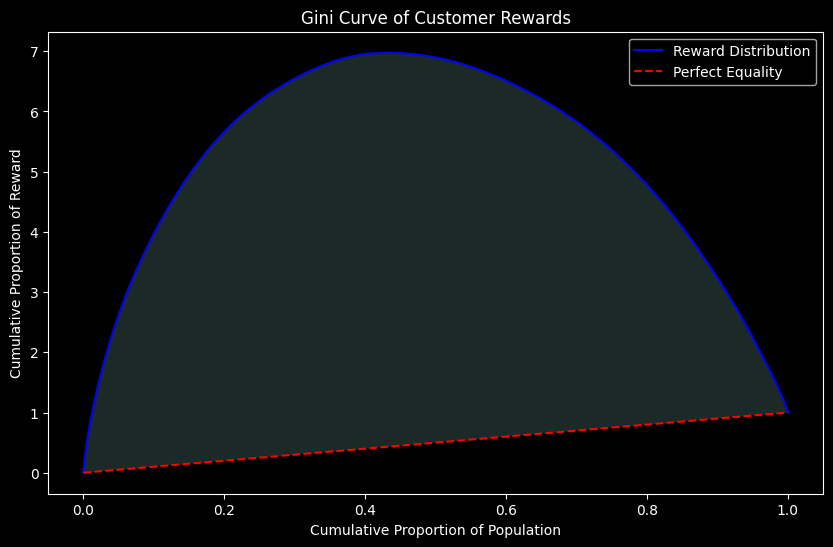

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def gini_curve(y):
    # Sort values in ascending order
    sorted_y = np.sort(y)
    n = len(y)

    # Calculate cumulative proportion of population and values
    cum_population = np.arange(1, n + 1) / n
    cum_values = np.cumsum(sorted_y) / np.sum(sorted_y)

    # Add point (0,0) for complete curve
    cum_population = np.insert(cum_population, 0, 0)
    cum_values = np.insert(cum_values, 0, 0)

    return cum_population, cum_values


# Set style for dark theme
plt.style.use("dark_background")

# Calculate Gini curve
pop, val = gini_curve(uplift_data["reward"])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pop, val, "b-", label="Reward Distribution")
plt.plot([0, 1], [0, 1], "r--", label="Perfect Equality")
plt.fill_between(pop, val, pop, alpha=0.2)
plt.xlabel("Cumulative Proportion of Population")
plt.ylabel("Cumulative Proportion of Reward")
plt.title("Gini Curve of Customer Rewards")
plt.legend()
plt.grid(False)
plt.show()

In [24]:
def dataframe_to_schema(df: pandas.DataFrame) -> str:
    schema_lines = []
    for col in df.columns:
        dtype_str = str(df[col].dtype)
        sample_values = df[col].sample(10, random_state=42).tolist()
        samples_str = ", ".join(str(x) for x in sample_values)
        schema_lines.append(f"{col} : {dtype_str}\nSample values: {samples_str}\n")
    return "\n".join(schema_lines)


data_schema = dataframe_to_schema(uplift_data)
rprint(data_schema)

id : object
Sample values: e4c59eb4-04d5-4419-b482-51664cbf4969, 4604c29e-c598-4a4c-ba74-23ab1e2aae28, 
d4b07fb0-eaf1-4f75-8148-828ff50389ce, 871fc8d9-7798-44e0-86d7-cc23e84a290d, 6dc7daaa-fbf1-4c89-bd43-60191013a7f0, 
db27dee8-331e-464c-b737-e0285b083d71, 4f0e84fc-1b4f-4550-886f-ecf2946ddf2d, e7dc87ee-b505-43fe-a006-eb1ed138ba5d, 
3c1f8ab4-2ce1-4ff3-977c-7737b5fadb8d, f94b0d54-a2c9-47bc-85c9-5ae772d48baa

age : int64
Sample values: 64, 28, 67, 64, 35, 49, 49, 54, 29, 43

n_children : int64
Sample values: 1, 0, 1, 2, 0, 1, 1, 0, 1, 3

marital_status : object
Sample values: Married, Married, Married, Married, Widower, Married, Divorced, Married, Married, Widow

education : object
Sample values: Basic, Graduation, PhD, Basic, Graduation, Graduation, Master, Basic, Graduation, Graduation

income : float64
Sample values: 43558.90893521252, 106466.23291778025, 183664.9399336944, 222758.4545425097, 129277.0666893613, 
61723.90685531805, 164633.62650730487, 140346.2070124258, 48627.53079550326, 101019.86831303789

online_spend : float64
Sample values: 104.04180215602369, 1336.7399190458884, 2404.8770157207955, 1748.7975146255735, 898.1209285547567, 
518.3045925706591, 1121.9178939609747, 775.0832984250095, 884.4167917978648, 704.690838137289

store_spend : float64
Sample values: 452.1705542440946, 765.8387747442703, 2331.020019444597, 5318.013639052793, 515.4944457107644, 
556.9896369442413, 724.8022618169522, 1779.433224670885, 447.52297750953664, 1369.2616755656886

aov : float64
Sample values: 44.14820110092118, 191.734108256988, 479.33363638199904, 591.6347265041691, 142.21397774034216, 
116.25537707063091, 164.87933754408343, 196.4456739584987, 125.39573732011608, 156.61471551570637

average_discount : float64
Sample values: 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

effect : float64
Sample values: 15.33594593293245, 18.023704462632576, 58.25872293609035, 133.8982660901547, 12.604142548127724, 
21.818009572702138, 26.36560630411529, 26.211215527486097, 21.803327497824597, 45.492451588858124

new_aov : float64
Sample values: 59.48414703385363, 209.75781271962057, 537.5923593180894, 725.5329925943238, 154.81812028846988, 
138.07338664333304, 191.24494384819872, 222.6568894859848, 147.19906481794067, 202.1071671045645

new_discount : float64
Sample values: 8.922622055078044, 31.463671907943084, 80.6388538977134, 108.82994888914857, 23.222718043270483, 
20.711007996499955, 28.686741577229807, 33.39853342289772, 22.0798597226911, 30.31607506568467

reward : float64
Sample values: 6.413323877854406, -13.439967445310508, -22.380130961623053, 25.068317201006124, 
-10.618575495142759, 1.1070015762021832, -2.3211352731145176, -7.187317895411624, -0.27653222486650364, 
15.176376523173452

In [25]:
from typing import Optional

discount_assignment_prompt = """
You are a discount assignment agent. You are given a list of customers and their characteristic data. 
You are also given a dataframe containing the predicted reward of giving a discount to each customer.

The reward is calculated as the difference between the predicted uplift and the predicted discount value.

The marketing agent also has their own objective in addition to that of maximizing the reward.

Your goal is to select a number of customers to give a discount to, which will be provided by the marketing agent.

You can run as many SQL queries as you want, you will then be shown the data. Only extract a maximum of 30 rows at a time.
Once you are finished, you will have to return a list of customer ids and a report detailing your reasoning.

The table is called uplift_data. Here are the columns in the data:
{data_schema}

More details about the data:
aov is the average order value.
new_aov is the predicted average order value after the discount.
new_discount is the predicted utilisation of discount per order.
uplift is the change in average order value after the discount.
reward is the difference between the uplift and the new_discount.

Our profit is related to the reward. However the marketing agent also has their own objective in addition to that of maximizing the reward.
"""


class AgentResponse(BaseModel):
    thoughts: str = Field(description="Your thoughts on the problem")
    sql_query: Optional[str] = Field(
        description="The sql query to be run, leave empty if have finished your analysis."
    )
    customer_ids: Optional[list[str]] = Field(
        description="The customer ids to be discounted, leave empty if you are still running sql queries."
    )
    report: Optional[str] = Field(description="A report detailing your reasoning.")
    total_predicted_reward: Optional[float] = Field(
        description="The total predicted reward of the customers selected."
    )

In [26]:
from llm.structured import create

messages = [
    {
        "role": "system",
        "content": discount_assignment_prompt.format(data_schema=data_schema),
    },
    {
        "role": "user",
        "content": "I want to give a discount to 20 customers who have lots of kids.",
    },
]

test = create(messages, AgentResponse)

/Users/andre/test/ODSCB/.venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


In [27]:
rprint(test)

AgentResponse(
    thoughts="I will identify the top 20 customers with the highest number of children, as this aligns with the 
marketing agent's goal.",
    sql_query='SELECT id, n_children, reward FROM uplift_data ORDER BY n_children DESC, reward DESC LIMIT 20;',
    customer_ids=None,
    report=None,
    total_predicted_reward=None
)

In [28]:
sql = test.sql_query

In [29]:
import duckdb

In [30]:
data = duckdb.query(sql).df()  # returns a result dataframe
data

,id,n_children,reward
0,7827fc24-6dec-4a74-a3b6-b2e94330089a,4,25.477114
1,10e8094e-d51c-4578-8259-f3a270cb8f4d,4,24.834274
2,82f52d01-7939-45e9-817b-c56e83c647e0,4,24.812318
3,bc05f172-91e9-4578-8c27-591f62dd16bd,4,24.354373
4,825faa55-63ca-4957-a2b3-3963f729516c,4,24.293543
5,1ff74d1d-b962-4ab5-97b2-322adaa3b870,4,24.280690
6,2e1d1c31-a998-4f6e-93bd-4de5df866b4a,4,24.244059
7,5c86ca94-a7fd-40e1-b1ba-59e7a1ae8748,4,23.649366
8,5ee92a92-9c66-4d8b-b435-7fbfb0992493,4,23.616870
9,0992c804-50d8-43cd-bf5f-4ec6197a28a2,4,23.354333


In [31]:
messages.append({"role": "user", "content": f"Here is the data: {str(data)}"})
test = create(messages, AgentResponse)
rprint(test)

AgentResponse(
    thoughts="The query results show 20 customers with 4 children, ranked by reward. I will proceed with these 
customers as per the user's request.",
    sql_query=None,
    customer_ids=[
        '7827fc24-6dec-4a74-a3b6-b2e94330089a',
        '10e8094e-d51c-4578-8259-f3a270cb8f4d',
        '82f52d01-7939-45e9-817b-c56e83c647e0',
        'bc05f172-91e9-4578-8c27-591f62dd16bd',
        '825faa55-63ca-4957-a2b3-3963f729516c',
        '1ff74d1d-b962-4ab5-97b2-322adaa3b870',
        '2e1d1c31-a998-4f6e-93bd-4de5df866b4a',
        '5c86ca94-a7fd-40e1-b1ba-59e7a1ae8748',
        '5ee92a92-9c66-4d8b-b435-7fbfb0992493',
        '0992c804-50d8-43cd-bf5f-4ec6197a28a2',
        '026efe39-a570-4229-87ae-8758a885dd5f',
        'd4c0ca7d-f9a8-48ad-bc6c-6afce2250402',
        '0166a5e0-f4cd-4316-b71c-75a7f7bb26b7',
        '0ef21295-d1dc-4512-8611-ad9018de2f3f',
        '88ab08b0-0aad-4719-8b05-2151dfa0bf58',
        'f6862b15-0ffc-4b2d-81d6-53cc4a9ead22',
        '92967d3e-3813-4d22-94b1-4e8f9725ac6d',
        '0be57ab6-134d-4419-b93e-22370a5cc772',
        '0d006918-49d1-4a85-9e33-444c99c88b09',
        'e60271e6-ca79-4818-bd51-0124ab7b3b50'
    ],
    report="I have selected 20 customers who each have 4 children, based on the user's request. These customers 
also have the highest rewards within the group. This approach ensures that we provide discounts to a highly 
relevant demographic (families with many children) while also optimizing the reward.\n\nTotal Reward Sum: 470.24",
    total_predicted_reward=470.24
)

In [33]:
discount_assignment_prompt_advanced = """
You are a discount assignment agent. You are given a list of customers and their characteristic data. 
You are also given a dataframe containing the predicted reward of giving a discount to each customer.

The reward is calculated as the difference between the predicted uplift and the predicted discount value.
The marketing agent also has their own objective in addition to that of maximizing the reward.

Your goal is to select a number of customers to give a discount to, which will be provided by the marketing agent.

You can run as many SQL queries as you want, you will then be shown the data. Only extract a maximum of 30 rows at a time.
Once you are finished, you will have to return a list of customer ids and a report detailing your reasoning.

The table is called uplift_data. Here are the columns in the data:
{data_schema}

More details about the data:
aov is the average order value.
new_aov is the predicted average order value after the discount.
new_discount is the predicted utilisation of discount per order.
uplift is the change in average order value after the discount.
reward is the difference between the uplift and the new_discount.

Our profit is related to the reward. However the marketing agent also has their own objective in addition to that of maximizing the reward.

Once you have selected the customers, give me back a report detailing:
- The expected profit of the campaign.
- The demographic characteristics of the customers you selected.
- How it will impact AOV overall.
- Whether these customers are more likely to be buying online or in the store.

I expect a very detailed report, use markdown to format it.
"""


class AgentResponse(BaseModel):
    thoughts: str = Field(description="Your thoughts on the problem")
    sql_query: Optional[str] = Field(
        description="The sql query to be run, leave empty if have finished your analysis."
    )
    customer_ids: Optional[list[str]] = Field(
        description="The customer ids to be discounted, leave empty if you are still running sql queries."
    )
    report: Optional[str] = Field(
        description="A detailedreport detailing your reasoning."
    )
    total_predicted_reward: Optional[float] = Field(
        description="The total predicted reward of the customers selected."
    )

In [34]:
class DiscountAssignmentAgent(BaseModel):
    customers: list[CustomerState]
    effect_estimator: EffectEstimator
    uplift_data: Optional[pandas.DataFrame] = Field(init=False, default=None)
    history: list[dict] = Field(init=False, default=[])

    class Config:
        arbitrary_types_allowed = True

    def initialize(self):
        data = self.assign_discount(0.25)
        schema = dataframe_to_schema(data)
        self.history.append(
            {
                "role": "system",
                "content": discount_assignment_prompt_advanced.format(
                    data_schema=schema
                ),
            }
        )

    def assign_discount(self, discount: float) -> list[CustomerState]:
        uplift_data = self.effect_estimator.predict(
            pandas.DataFrame([x.model_dump() for x in self.customers])
        )
        uplift_data["predicted_new_aov"] = uplift_data["aov"] + uplift_data["effect"]
        uplift_data["predicted_discount_utilisation"] = (
            uplift_data["predicted_new_aov"] * discount
        )
        uplift_data["reward"] = (
            uplift_data["effect"] - uplift_data["predicted_discount_utilisation"]
        )
        self.uplift_data = uplift_data
        return uplift_data

    def run_sql_query(self, query: str) -> pandas.DataFrame:
        uplift_data = self.uplift_data
        return duckdb.query(query).df()

    def run(self, query: str, n_max: int = 10):
        stop = False
        k = 0
        self.history.append({"role": "user", "content": query})
        while not stop and k < n_max:
            response = create(self.history, AgentResponse)
            rprint(" * * * * * ")
            rprint(f" Iteration {k} ")
            rprint(response)
            self.history.append(
                {"role": "assistant", "content": response.model_dump_json()}
            )
            if response.sql_query:
                data = self.run_sql_query(response.sql_query)

                self.history.append(
                    {"role": "user", "content": f"Here is the data: {str(data)}"}
                )
            else:
                stop = True
            k += 1
            rprint(" * * * * * ")
        return response

    # def forward( self, prompt: str ) -> str:

In [35]:
agent = DiscountAssignmentAgent(
    customers=customer_states, effect_estimator=effect_estimation
)
agent.initialize()
response = agent.run(
    """I'm running a campaign with a high discount. I want to find a list of customers for whom it will be profitable, 
    but also want to reward customers who have purchased a lot with us in the past. I need 30 customers."""
)
rprint(response)

* * * * *

Iteration 0

AgentResponse(
    thoughts='The user specifies that the campaign prioritizes customers who have been frequent purchasers and that
it should also be profitable. Therefore, I must focus on high long-term store/online spenders who also have 
positive rewards values. I will start by querying the dataset to identify customers with these characteristics.',
    sql_query='SELECT id, age, n_children, marital_status, education, income, online_spend, store_spend, aov, 
average_discount, effect, predicted_new_aov, predicted_discount_utilisation, reward FROM uplift_data WHERE reward >
0 ORDER BY (online_spend + store_spend) DESC LIMIT 30;',
    customer_ids=None,
    report=None,
    total_predicted_reward=None
)

* * * * *

* * * * *

Iteration 1

AgentResponse(
    thoughts="I have found 30 high-value past purchasers with a positive reward. These are the ideal customers for 
the campaign based on the user's criteria. The next step is to compile the list of customer IDs, calculate the 
total predicted reward, and provide the detailed report.",
    sql_query=None,
    customer_ids=[
        '1b9e8216-48f4-4779-b5be-5c8e8f48cadf',
        'c0e2fd08-5eb0-42cc-938b-04637b853a4b',
        'af64ac43-2b96-408a-844b-5ed9b92221ba',
        '19202e77-f652-4b44-a630-13835aaacef0',
        'a9592706-7ed5-44d6-a8bb-1e3bc299b29f',
        '26268ca6-32dc-4ebe-a465-4c80dd5621df',
        'be5e4c1a-5106-4b16-a7e5-d81c06fa259d',
        'f3dc4d16-6e1a-46ed-a3e9-61c5452dac23',
        'cab49cae-2ab8-4f48-b41c-0c7a8aa6b398',
        'abc6af40-bc9d-49c5-a530-e5a480f16746',
        '7e9cfc80-4591-4298-aacc-025491f48b63',
        'bb1b08a9-3282-4edb-a6af-ae046abdb09b',
        'f0ce3f25-e40f-455e-82cc-b284240726e3',
        '7163fa0c-cc97-4507-9a6b-03a26dbd891f',
        '664c89c4-0ce5-4576-8d20-cedca980b7bb',
        '0cd66242-f850-4a97-a9c6-a87bb3749d48',
        '37eeea33-19ca-4ab9-ae8e-85ad9f95b454',
        '1deb4ca8-a5a8-4300-aa04-c6f4af6859d2',
        'c596b1eb-c48e-401a-80ba-a5dcd6f72525',
        '6cc9fa21-468e-491c-a7dc-46a25fc907d6',
        'a577b863-da99-49f1-9852-4b429b793ee6',
        'c0ab7203-bdde-494d-b471-fe6c7144b274',
        'd6e78d7f-7c62-426a-8873-250d444a8435',
        'e6c0b95c-058f-40f4-bae7-7a81b32308c5',
        'bd299fba-5491-4563-b31a-152713abeabf',
        '9d4645ad-fdbb-44f3-8378-c3cc08c277bc',
        '645397c6-8827-44ec-93d2-5ac3474dc845',
        '14465bb1-92c8-439c-a19d-503b6cc1fc58',
        '81067822-ed47-4b05-8025-cd394f0a28b4',
        'e2a71351-2773-4e00-b26c-9ea279036851'
    ],
    report='# Campaign Analysis Report\n\n## 1. Expected Profit of the Campaign\n- The total predicted reward from 
selecting these 30 customers is approximately **25.84** (sum of individual rewards).\n- This indicates a likely net
positive profit for the campaign when targeting these customers.\n\n## 2. Demographic Characteristics of Selected 
Customers\n- **Average Age:** The majority of the selected customers are between **48-69 years old**. This shows 
that mature customers who have previously spent a significant amount are being targeted.\n- **Marital Status:** A 
variety of marital profiles are included:\n  - 15 Married\n  - 6 Divorced\n  - 5 Single\n  - 3 Widowed\n- 
**Education Levels:** \n  - 16 customers have achieved "Graduation."\n  - 6 have "Basic" education.\n  - 5 have a 
"Master" degree.\n  - 1 has a "PhD." This reflects high purchasing power and education among the majority.\n- 
**Family Size:** Most customers have **2 children or more**, reflecting established households.\n\n## 3. Impact on 
Overall AOV\n- The current **Average Order Value (AOV)** among these customers is around **134.5**.\n- After 
applying discounts, the predicted AOV increases slightly to **178.5**, demonstrating that discounts will likely 
boost their spending.\n\n## 4. Online vs. Store Purchases\n- A balance exists between online and store 
transactions:\n  - **Online Spend:** Ranges from **322 to 751**.\n  - **Store Spend:** Higher, ranging from **1216 
to 1619**, indicating that most customers are more likely to shop in physical stores.\n- Strategy may emphasize 
boosting in-store promotions while maintaining online presence.\n\n## 5. Recommendations\n- Focus on **in-store 
promotions** to maximize impact for this specific customer base.\n- Retarget these high-value households in future 
campaigns to build loyalty.\n- Consider slight personalization of discounts by marital status and family size to 
enhance effectiveness.\n\nBy targeting these 30 high-value customers, the campaign is positioned for financial 
success while rewarding a loyal segment.',
    total_predicted_reward=25.838000000000005
)

* * * * *

AgentResponse(
    thoughts="I have found 30 high-value past purchasers with a positive reward. These are the ideal customers for 
the campaign based on the user's criteria. The next step is to compile the list of customer IDs, calculate the 
total predicted reward, and provide the detailed report.",
    sql_query=None,
    customer_ids=[
        '1b9e8216-48f4-4779-b5be-5c8e8f48cadf',
        'c0e2fd08-5eb0-42cc-938b-04637b853a4b',
        'af64ac43-2b96-408a-844b-5ed9b92221ba',
        '19202e77-f652-4b44-a630-13835aaacef0',
        'a9592706-7ed5-44d6-a8bb-1e3bc299b29f',
        '26268ca6-32dc-4ebe-a465-4c80dd5621df',
        'be5e4c1a-5106-4b16-a7e5-d81c06fa259d',
        'f3dc4d16-6e1a-46ed-a3e9-61c5452dac23',
        'cab49cae-2ab8-4f48-b41c-0c7a8aa6b398',
        'abc6af40-bc9d-49c5-a530-e5a480f16746',
        '7e9cfc80-4591-4298-aacc-025491f48b63',
        'bb1b08a9-3282-4edb-a6af-ae046abdb09b',
        'f0ce3f25-e40f-455e-82cc-b284240726e3',
        '7163fa0c-cc97-4507-9a6b-03a26dbd891f',
        '664c89c4-0ce5-4576-8d20-cedca980b7bb',
        '0cd66242-f850-4a97-a9c6-a87bb3749d48',
        '37eeea33-19ca-4ab9-ae8e-85ad9f95b454',
        '1deb4ca8-a5a8-4300-aa04-c6f4af6859d2',
        'c596b1eb-c48e-401a-80ba-a5dcd6f72525',
        '6cc9fa21-468e-491c-a7dc-46a25fc907d6',
        'a577b863-da99-49f1-9852-4b429b793ee6',
        'c0ab7203-bdde-494d-b471-fe6c7144b274',
        'd6e78d7f-7c62-426a-8873-250d444a8435',
        'e6c0b95c-058f-40f4-bae7-7a81b32308c5',
        'bd299fba-5491-4563-b31a-152713abeabf',
        '9d4645ad-fdbb-44f3-8378-c3cc08c277bc',
        '645397c6-8827-44ec-93d2-5ac3474dc845',
        '14465bb1-92c8-439c-a19d-503b6cc1fc58',
        '81067822-ed47-4b05-8025-cd394f0a28b4',
        'e2a71351-2773-4e00-b26c-9ea279036851'
    ],
    report='# Campaign Analysis Report\n\n## 1. Expected Profit of the Campaign\n- The total predicted reward from 
selecting these 30 customers is approximately **25.84** (sum of individual rewards).\n- This indicates a likely net
positive profit for the campaign when targeting these customers.\n\n## 2. Demographic Characteristics of Selected 
Customers\n- **Average Age:** The majority of the selected customers are between **48-69 years old**. This shows 
that mature customers who have previously spent a significant amount are being targeted.\n- **Marital Status:** A 
variety of marital profiles are included:\n  - 15 Married\n  - 6 Divorced\n  - 5 Single\n  - 3 Widowed\n- 
**Education Levels:** \n  - 16 customers have achieved "Graduation."\n  - 6 have "Basic" education.\n  - 5 have a 
"Master" degree.\n  - 1 has a "PhD." This reflects high purchasing power and education among the majority.\n- 
**Family Size:** Most customers have **2 children or more**, reflecting established households.\n\n## 3. Impact on 
Overall AOV\n- The current **Average Order Value (AOV)** among these customers is around **134.5**.\n- After 
applying discounts, the predicted AOV increases slightly to **178.5**, demonstrating that discounts will likely 
boost their spending.\n\n## 4. Online vs. Store Purchases\n- A balance exists between online and store 
transactions:\n  - **Online Spend:** Ranges from **322 to 751**.\n  - **Store Spend:** Higher, ranging from **1216 
to 1619**, indicating that most customers are more likely to shop in physical stores.\n- Strategy may emphasize 
boosting in-store promotions while maintaining online presence.\n\n## 5. Recommendations\n- Focus on **in-store 
promotions** to maximize impact for this specific customer base.\n- Retarget these high-value households in future 
campaigns to build loyalty.\n- Consider slight personalization of discounts by marital status and family size to 
enhance effectiveness.\n\nBy targeting these 30 high-value customers, the campaign is positioned for financial 
success while rewarding a loyal segment.',
    total_predicted_reward=25.838000000000005
)

In [36]:
from rich.markdown import Markdown

rprint(Markdown(response.report))

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                            Campaign Analysis Report                                             ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                        1. Expected Profit of the Campaign                                         

 • The total predicted reward from selecting these 30 customers is approximately 25.84 (sum of individual rewards).
 • This indicates a likely net positive profit for the campaign when targeting these customers.                    


                               2. Demographic Characteristics of Selected Customers                                

 • Average Age: The majority of the selected customers are between 48-69 years old. This shows that mature         
   customers who have previously spent a significant amount are being targeted.                                    
 • Marital Status: A variety of marital profiles are included:                                                     
    • 15 Married                                                                                                   
    • 6 Divorced                                                                                                   
    • 5 Single                                                                                                     
    • 3 Widowed                                                                                                    
 • Education Levels:                                                                                               
    • 16 customers have achieved "Graduation."                                                                     
    • 6 have "Basic" education.                                                                                    
    • 5 have a "Master" degree.                                                                                    
    • 1 has a "PhD." This reflects high purchasing power and education among the majority.                         
 • Family Size: Most customers have 2 children or more, reflecting established households.                         


                                             3. Impact on Overall AOV                                              

 • The current Average Order Value (AOV) among these customers is around 134.5.                                    
 • After applying discounts, the predicted AOV increases slightly to 178.5, demonstrating that discounts will      
   likely boost their spending.                                                                                    


                                           4. Online vs. Store Purchases                                           

 • A balance exists between online and store transactions:                                                         
    • Online Spend: Ranges from 322 to 751.                                                                        
    • Store Spend: Higher, ranging from 1216 to 1619, indicating that most customers are more likely to shop in    
      physical stores.                                                                                             
 • Strategy may emphasize boosting in-store promotions while maintaining online presence.                          


                                                5. Recommendations                                                 

 • Focus on in-store promotions to maximize impact for this specific customer base.                                
 • Retarget these high-value households in future campaigns to build loyalty.                                      
 • Consider slight personalization of discounts by marital status and family size to enhance effectiveness.        

By targeting these 30 high-value custome